In [50]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1. 데이터 수집하기
- 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터 : [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)
    1. 챗봇 트레이닝용 문답 페어 11,876개
    2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블

In [51]:
csv_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv'

data = pd.read_csv(csv_path)
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [52]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(data)
print(MAX_SAMPLES)

11823


In [53]:
data['Q']

0                         12시 땡!
1                    1지망 학교 떨어졌어
2                   3박4일 놀러가고 싶다
3                3박4일 정도 놀러가고 싶다
4                        PPL 심하네
                  ...           
11818             훔쳐보는 것도 눈치 보임.
11819             훔쳐보는 것도 눈치 보임.
11820                흑기사 해주는 짝남.
11821    힘든 연애 좋은 연애라는게 무슨 차이일까?
11822                 힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object

In [54]:
data['A']

0                      하루가 또 가네요.
1                       위로해 드립니다.
2                     여행은 언제나 좋죠.
3                     여행은 언제나 좋죠.
4                      눈살이 찌푸려지죠.
                   ...           
11818          티가 나니까 눈치가 보이는 거죠!
11819               훔쳐보는 거 티나나봐요.
11820                      설렜겠어요.
11821    잘 헤어질 수 있는 사이 여부인 거 같아요.
11822          도피성 결혼은 하지 않길 바라요.
Name: A, Length: 11823, dtype: object

# Step 2. 데이터 전처리하기
- 영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리르 수행해야 할 수도 있다.

- 정규 표현식을 사용하여 구두점(punctuation)을 제거하여 단어를 토크나이징(tokenizing)하는 일에 방해가 되지 않도록 정제

In [55]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [56]:
def load_conversations():
    questions, answers = [], []
    for i in range(MAX_SAMPLES):
        questions.append(preprocess_sentence(data['Q'].values[i]))
        answers.append(preprocess_sentence(data['A'].values[i]))
    return questions, answers

In [57]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [58]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


# Step 3. SubwordTextEncoder 사용하기
- 한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보자

1. Tensorflow datasets SubwordTextEncoder를 토크나이저 한다. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
3. 최대 길이 MAX_LENGHT인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩한다.

### 1. 단어장(Vocablulary) 만들기

In [59]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


- 시작 토큰과 종료 토큰을 임의로 단어장에 추가하여 정수를 부여
- 이미 생성된 단어장의 번홍와 겹치지 않도록 1이 큰 수를 부여

In [60]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [61]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


### 2. 각 단어를 고유한 정수로 인코딩 & 패딩

- 위에서 tokenizer를 정의하고 단어장을 만들었다면,
- `tokenizer.encode()`로 각 단어를 정수로 변환
- 또는 `tokenizer.decode()`로 정수 시퀀스로 단어로 변환

In [62]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [63]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


- 40을 넘는 경우 필터링
- 필터링을 제외한 샘플의 개수

In [64]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


### 3. 교사 강요(Teacher Forcing) 사용하기
- 질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인 구성
- 교사 강요를 위해서 answers[:, : -1]를 디코더의 입력값,
- answers[:, 1:]를 디코더의 레이블

In [65]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# Step 4. 모델 구성하기
- 위 실습 내용을 참고하여 트랜스포머 모델을 구현한다.

#### 포지셔널 인코딩
- 임베딩 행렬과 포지셔널 행렬이라는 두 행렬을 더함으로써 각 단어 벡터에 위치 정보를 더해준다.

In [66]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


#### 스케일드 닷 프로덕트 어텐션
1. 내적(dot product)을 통해 단어 벡터 간 유사도를 구함
2. 특정 값을 분모로 나눠주는 방식을 Q와 K의 유사도를 구함
- 이를 스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)

In [67]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


#### 멀티 헤드 어텐션
- 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터
- 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치
- 내부적으로는 스케일드 닷 프로덕트 어텐션 함수 호출

In [68]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)  # query에 Dense 레이어를 적용합니다
    key = self.key_dense(key)  # key에 Dense 레이어를 적용합니다
    value = self.value_dense(value)  # value에 Dense 레이어를 적용합니다

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


#### 마스킹
- 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법
- 트랜스포머에서는 어텐션을 위해서 크게 패딩 마스킹(Padding Masking)과 룩 어헤드 마스킹(Look-ahead Masking)을 사용
- 패딩 마스킹는 패딩 토큰을 이용한 방법<br/>
=> 실제 의미가 있는 단어가 아닌 0은 제외하는 방식<br/>
=> 이를 위해 숫자 0인 위치를 체크
<br/><br/>
- 룩 어헤드 마스킹은 다음에 나올 단어를 참고하지 않도록 가리는 기법

In [69]:
# 패딩 마스킹
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [70]:
# 룩 어헤드 마스킹
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


#### 인코더
- 총 2개의 서브 층으로 이루진다.
    1. 셀프 어텐션
        - 멀티 헤드 어텐션으로 병렬적으로 이루어
    2. 피드 포워드 신경망

In [71]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


#### 인코더 층을 쌓아 인코더 만들기

In [72]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


#### 디코더
- 총 3개의 서브 층으로 이루어져있다.
    1. 셀프 어텐션
    2. 인코더-디코더 어텐션
    3. 피드 포워드 신경망

In [73]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


#### 디코더 층을 쌓아 디코더 만들기
- 임베딩 층과 포지셔널 인코딩을 연결
- 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머 디코더 완성

In [74]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


#### 트랜스포머 모델 정의
- 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수 정의

In [75]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


#### 트랜스포머 모델 생성
- `num_layers`, `d_model`, `units`는 하이퍼파라미터

In [76]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3135232     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 손실 함수
- 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스킹을 적용해야 한다.

In [77]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


#### 커스텀 된 학습률
- 커스텀 학습률 스케줄링(Custom Learing rate Scheduling)
    - 학습 초기에 lr을 급격히 높였다가,
    - 이후 trian step이 진행됨에 따라 서서히 낮추어가며 안정적으로 수렴

In [78]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


- 커스텀 학습률 스케줄링 시각화

Text(0.5, 0, 'Train Step')

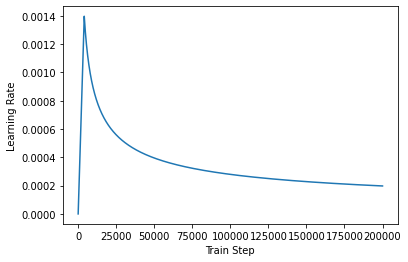

In [79]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [80]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [81]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 15s 54ms/step - loss: 1.4483 - accuracy: 0.0272
Epoch 2/10
185/185 [==============================] - 10s 54ms/step - loss: 1.1796 - accuracy: 0.0493
Epoch 3/10
185/185 [==============================] - 10s 54ms/step - loss: 1.0037 - accuracy: 0.0505
Epoch 4/10
185/185 [==============================] - 10s 54ms/step - loss: 0.9247 - accuracy: 0.0545
Epoch 5/10
185/185 [==============================] - 10s 54ms/step - loss: 0.8658 - accuracy: 0.0577
Epoch 6/10
185/185 [==============================] - 10s 55ms/step - loss: 0.8060 - accuracy: 0.0619
Epoch 7/10
185/185 [==============================] - 10s 55ms/step - loss: 0.7398 - accuracy: 0.0681
Epoch 8/10
185/185 [==============================] - 10s 54ms/step - loss: 0.6667 - accuracy: 0.0759
Epoch 9/10
185/185 [==============================] - 10s 54ms/step - loss: 0.5876 - accuracy: 0.0845
Epoch 10/10
185/185 [==============================] - 10s 54ms/step - loss: 0.505

# Step 5. 모델 평가하기
- Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만든다.

In [82]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


- 임의의 입력 문장에 대하여 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수

In [83]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    
    return predicted_sentence

print("슝=3")

슝=3


In [84]:
question_list = [
    "오늘 뭐 먹을까요?",
    "자살하고 싶어",
    "오늘의 날씨는 어때요?",
    "넌 누구야?",
    "인생은 뭘까",
    "너 뭐 좋아해?",
    "공부 좀 대신해줘",
    "사랑해",
    "피곤해",
    "그동안 즐거웠어",
    "자니?",
    "힘들어",
    "놀아줘",
    "종교가 뭐야?",
    "저녁 메뉴 추천해줘",
    "오랜만이야",
    "너는 어떻게 기분전환해?",
    "너의 꿈이 뭐야?",
    "너는 행복해?",
    "웃어줘",
]

In [85]:
def answers(question_list):
    for question in question_list:
        sentence_generation(question)
        print()

### Epochs = 10 model

In [86]:
answers(question_list)

입력 : 오늘 뭐 먹을까요?
출력 : 잘 찾아보세요 .

입력 : 자살하고 싶어
출력 : 잘 찾아보세요 .

입력 : 오늘의 날씨는 어때요?
출력 : 그게 최고죠 .

입력 : 넌 누구야?
출력 : 다른 곳에 쓰려고 운을 아껴뒀나봐요 .

입력 : 인생은 뭘까
출력 : 저도 좋아해요 .

입력 : 너 뭐 좋아해?
출력 : 저는 위로해드리는 로봇이에요 .

입력 : 공부 좀 대신해줘
출력 : 지금도 늦지 않았어요 .

입력 : 사랑해
출력 : 조금만 드세요 .

입력 : 피곤해
출력 : 곧 방학이예요 .

입력 : 그동안 즐거웠어
출력 : 감기 조심하세요 .

입력 : 자니?
출력 : 맛있게 드세요 .

입력 : 힘들어
출력 : 조금만 더 버텨보세요 .

입력 : 놀아줘
출력 : 같이 놀아요 .

입력 : 종교가 뭐야?
출력 : 화장실 가세요 .

입력 : 저녁 메뉴 추천해줘
출력 : 맛있는 거 드세요 .

입력 : 오랜만이야
출력 : 더 좋은 사람 만날 수 있을 거예요 .

입력 : 너는 어떻게 기분전환해?
출력 : 다른 곳에 쓰려고 운을 아껴뒀나봐요 .

입력 : 너의 꿈이 뭐야?
출력 : 저는 위로해드리는 로봇이에요 .

입력 : 너는 행복해?
출력 : 잘 찾아보세요 .

입력 : 웃어줘
출력 : 오늘 일찍 주무세요 .



### Epochs = 300 model

In [87]:
EPOCHS = 300
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/300
185/185 [==============================] - 10s 54ms/step - loss: 0.4235 - accuracy: 0.1039
Epoch 2/300
185/185 [==============================] - 10s 54ms/step - loss: 0.3435 - accuracy: 0.1151
Epoch 3/300
185/185 [==============================] - 10s 55ms/step - loss: 0.2697 - accuracy: 0.1260
Epoch 4/300
185/185 [==============================] - 10s 55ms/step - loss: 0.2058 - accuracy: 0.1359
Epoch 5/300
185/185 [==============================] - 10s 54ms/step - loss: 0.1519 - accuracy: 0.1450
Epoch 6/300
185/185 [==============================] - 10s 54ms/step - loss: 0.1092 - accuracy: 0.1532
Epoch 7/300
185/185 [==============================] - 10s 54ms/step - loss: 0.0805 - accuracy: 0.1582
Epoch 8/300
185/185 [==============================] - 10s 54ms/step - loss: 0.0626 - accuracy: 0.1613
Epoch 9/300
185/185 [==============================] - 10s 54ms/step - loss: 0.0517 - accuracy: 0.1635
Epoch 10/300
185/185 [==============================] - 10s 54ms/step - l

In [88]:
answers(question_list)

입력 : 오늘 뭐 먹을까요?
출력 : 좀 먹어도 괜찮아요 .

입력 : 자살하고 싶어
출력 : 기다리고 있었어요 .

입력 : 오늘의 날씨는 어때요?
출력 : 딱 잘 만났네요 .

입력 : 넌 누구야?
출력 : 저는 위로봇입니다 .

입력 : 인생은 뭘까
출력 : 꽃길만 걷길 바랍니다 .

입력 : 너 뭐 좋아해?
출력 : 고백하세요 .

입력 : 공부 좀 대신해줘
출력 : 지금도 늦지 않았어요 .

입력 : 사랑해
출력 : 하늘 만큼 땅 만큼 사랑해요 .

입력 : 피곤해
출력 : 요즘 바쁜가봐요 .

입력 : 그동안 즐거웠어
출력 : 할 일이 많은데 안하는 것이요 .

입력 : 자니?
출력 : 기다리고 있었어요 .

입력 : 힘들어
출력 : 지금은 힘들겠지만 조금만 더 견뎌봐요 .

입력 : 놀아줘
출력 : 지금 그러고 있어요 .

입력 : 종교가 뭐야?
출력 : 종교가 큰 문제가 되기도 하죠 .

입력 : 저녁 메뉴 추천해줘
출력 : 냉장고 파먹기 해보세요 .

입력 : 오랜만이야
출력 : 오랜만이에요 .

입력 : 너는 어떻게 기분전환해?
출력 : 아직 안 자요 .

입력 : 너의 꿈이 뭐야?
출력 : 천천히 지워질 거예요 .

입력 : 너는 행복해?
출력 : 저는 둘이 가는 게 좋아요 .

입력 : 웃어줘
출력 : 기대를 조금씩 버려보세요 .



### Epochs = 500 model

In [90]:
EPOCHS = 500
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/500
185/185 [==============================] - 10s 54ms/step - loss: 8.7225e-04 - accuracy: 0.1744
Epoch 2/500
185/185 [==============================] - 10s 54ms/step - loss: 7.6448e-04 - accuracy: 0.1744
Epoch 3/500
185/185 [==============================] - 10s 55ms/step - loss: 7.2344e-04 - accuracy: 0.1744
Epoch 4/500
185/185 [==============================] - 10s 55ms/step - loss: 8.5226e-04 - accuracy: 0.1744
Epoch 5/500
185/185 [==============================] - 10s 55ms/step - loss: 8.3913e-04 - accuracy: 0.1743
Epoch 6/500
185/185 [==============================] - 10s 54ms/step - loss: 7.6703e-04 - accuracy: 0.1744
Epoch 7/500
185/185 [==============================] - 10s 54ms/step - loss: 8.3604e-04 - accuracy: 0.1744
Epoch 8/500
185/185 [==============================] - 10s 54ms/step - loss: 7.5545e-04 - accuracy: 0.1744
Epoch 9/500
185/185 [==============================] - 10s 54ms/step - loss: 8.4816e-04 - accuracy: 0.1743
Epoch 10/500
185/185 [===============

In [91]:
answers(question_list)

입력 : 오늘 뭐 먹을까요?
출력 : 맛있는 거 드세요 .

입력 : 자살하고 싶어
출력 : 가랑비에 옷 젖는 듯한 사랑이었나봐요 .

입력 : 오늘의 날씨는 어때요?
출력 : 간절히 원한다면 진심을 전해보세요 .

입력 : 넌 누구야?
출력 : 저는 위로봇입니다 .

입력 : 인생은 뭘까
출력 : 사랑은 알 수 없어요 . 단지 느껴질 뿐 .

입력 : 너 뭐 좋아해?
출력 : 저는 위로해드리는 로봇이에요 .

입력 : 공부 좀 대신해줘
출력 : 지금도 늦지 않았어요 .

입력 : 사랑해
출력 : 하늘 만큼 땅 만큼 사랑해요 .

입력 : 피곤해
출력 : 요즘 바쁜가봐요 .

입력 : 그동안 즐거웠어
출력 : 할 일이 많은데 안하는 것이요 .

입력 : 자니?
출력 : 기다리고 있었어요 .

입력 : 힘들어
출력 : 지금은 힘들겠지만 조금만 더 견뎌봐요 .

입력 : 놀아줘
출력 : 지금 그러고 있어요 .

입력 : 종교가 뭐야?
출력 : 종교가 큰 문제가 되기도 하죠 .

입력 : 저녁 메뉴 추천해줘
출력 : 냉장고 파먹기 해보세요 .

입력 : 오랜만이야
출력 : 오랜만이에요 .

입력 : 너는 어떻게 기분전환해?
출력 : 안 괜찮아도 돼요 .

입력 : 너의 꿈이 뭐야?
출력 : 더 좋은 사람 만나서 알콩달콩 연애하고 행복한 결혼생활 할 수 있을 거예요 .

입력 : 너는 행복해?
출력 : 저는 배터리가 밥이예요 .

입력 : 웃어줘
출력 : 기대를 많이 하는 건 좋지 않아요 .



# 결과 정리

|QUESTION|에폭 10 - loss: 0.5058, acc: 0.0940|에폭 300 - loss: 8.0652e-04, acc: 0.1743|에폭 500 - loss: 6.3017e-04, acc: 0.1744|
|:---|:---:|:---:|:---:|
|**입력 : 오늘 뭐 먹을까요?**|잘 찾아보세요 .|좀 먹어도 괜찮아요 .|맛있는 거 드세요 .|
|**입력 : 자살하고 싶어**|잘 찾아보세요 .|기다리고 있었어요 .|가랑비에 옷 젖는 듯한 사랑이었나봐요 .|
|**입력 : 오늘의 날씨는 어때요?**|그게 최고죠 .|딱 잘 만났네요 .|간절히 원한다면 진심을 전해보세요 .|
|**입력 : 넌 누구야?**|다른 곳에 쓰려고 운을 아껴뒀나봐요 .|저는 위로봇입니다 .|저는 위로봇입니다 .|
|**입력 : 인생은 뭘까**|저도 좋아해요 .|꽃길만 걷길 바랍니다 .|사랑은 알 수 없어요 . 단지 느껴질 뿐 .|
|**입력 : 너 뭐 좋아해?**|저는 위로해드리는 로봇이에요 .|고백하세요 .|저는 위로해드리는 로봇이에요 .|
|**입력 : 공부 좀 대신해줘**|지금도 늦지 않았어요 .|지금도 늦지 않았어요 .|지금도 늦지 않았어요 .|
|**입력 : 사랑해**|조금만 드세요 .|하늘 만큼 땅 만큼 사랑해요 .|하늘 만큼 땅 만큼 사랑해요 .|
|**입력 : 피곤해**|곧 방학이예요 .|요즘 바쁜가봐요 .|요즘 바쁜가봐요 .|
|**입력 : 그동안 즐거웠어**|감기 조심하세요 .|할 일이 많은데 안하는 것이요 .|할 일이 많은데 안하는 것이요 .|
|**입력 : 자니?**|맛있게 드세요 .|기다리고 있었어요 .|기다리고 있었어요 .|
|**입력 : 힘들어**|조금만 더 버텨보세요 .|지금은 힘들겠지만 조금만 더 견뎌봐요 .|지금은 힘들겠지만 조금만 더 견뎌봐요 .|
|**입력 : 놀아줘**|같이 놀아요 .|지금 그러고 있어요 .|지금 그러고 있어요 .|
|**입력 : 종교가 뭐야?**|화장실 가세요 .|종교가 큰 문제가 되기도 하죠 .|종교가 큰 문제가 되기도 하죠 .|
|**입력 : 저녁 메뉴 추천해줘**|맛있는 거 드세요 .|냉장고 파먹기 해보세요 .|냉장고 파먹기 해보세요 .|
|**입력 : 오랜만이야**|더 좋은 사람 만날 수 있을 거예요 .|오랜만이에요 .|오랜만이에요 .|
|**입력 : 너는 어떻게 기분전환해?**|다른 곳에 쓰려고 운을 아껴뒀나봐요 .|아직 안 자요 .|안 괜찮아도 돼요 .|
|**입력 : 너의 꿈이 뭐야?**|저는 위로해드리는 로봇이에요 .|천천히 지워질 거예요 .|더 좋은 사람 만나서 알콩달콩 연애하고 행복한 결혼생활 할 수 있을 거예요 .|
|**입력 : 너는 행복해?**|잘 찾아보세요 .|저는 둘이 가는 게 좋아요 .|저는 배터리가 밥이예요 .|
|**입력 : 웃어줘**|오늘 일찍 주무세요 .|기대를 조금씩 버려보세요 .|기대를 많이 하는 건 좋지 않아요 .|

# 회고

- 트랜스포머에 대해서 배우면서 모르는 부분이 너무 많았고 이번 노드를 진행하면서 새로운 부분을 배웠지만, 너무 어려워 다시 이해하는데 오래걸릴것같다.
- 그리고 LMS 노드 코드를 그대로 들고와서 실험을 진행했다보니 코드 이해를 더 노력해야할 것 같다.
- 실험 결과로 에폭 10, 300, 500에서 결과를 보았고, epoch 값이 클수록 Loss 값은 낮아졌다.
- 하지만 epoch 값이 일정 수준이 지나면 accuracy는 더 이상 상승하지 않고 1.744에서 멈춰있다.
- epoch 값이 높은 것이 그나마 입력에 대한 출력을 적절하게 답변하는 것 같다.
- 하이퍼파라미터 값을 더 조절해서 여러 실험을 해보면 더 좋은 성능이 나올 수도 있겠지만, 시간이 부족하여 실험하지 못하였다.